In [46]:
import pandas as pd
from scipy.stats import kstest, norm
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### 0. Configuration

Feature glossary: <br />
<ul>
<li>gender -> {0, 1} = {female, male}</li>
<li>rf (risk factors) -> {0, 1} = {no, yes}</li>
<li>sbp -> systolic blood pressure</li>
<li>hr{1, 2} -> heart rate {1, 2}</li>
<li>st -> st deviation -> {0, 1} = {no, yes}</li>
<li>crt -> creatinine</li>
<li>kil -> kilip class -> {1, 2, 3, 4}</li>
<li>target -> cardiovascular event ? {0, 1} = {no, yes}</li>
<li>cg -> clinical guidelines, defined in 1.c</li>
</ul>

In [47]:
datasetsFolder = '../datasets'
datasetName = f'{datasetsFolder}/DATA.txt'
datasetColumns = [
    'gender', 'age', 'rf',
    'sbp', 'hr1', 'st',
    'hr2', 'crt', 'kil',
    'target'
]
heartRateStd = {'hr1': 2, 'hr2': 0.5}

### 1. Importing and pre-processing the data

#### Importing the dataset

In [48]:
dataset = pd.read_csv(datasetName, sep='   ', header=None, engine='python')
dataset.columns = datasetColumns

#### Pre-processing

a. Convert discrete values to integer type

In [49]:
def convertToDataType(dataset, cols, datatype):
    for col in cols:
        dataset[col] = dataset[col].astype(datatype)
    return dataset

In [50]:
dataset = convertToDataType(
    dataset, 
    ['gender', 'age', 'rf', 'st', 'kil', 'target'],
    int
)

b. Get HR estimation based on hr1 and hr2

<img src='../images/two-sensor-data-fusion-1.png'></img>
<img src='../images/two-sensor-data-fusion-2.png'></img>

In [51]:
def getEstimation(dataset, std):
    std1Squared = std['hr1'] ** 2
    std2Squared = std['hr2'] ** 2
    k1 = std2Squared / (std1Squared + std2Squared)
    _k1 = std1Squared / (std1Squared + std2Squared)
    return k1 * dataset['hr1'] + _k1 * dataset['hr2']


In [52]:
dataset['hr'] = getEstimation(dataset, heartRateStd)

c. Add clinical guidelines to dataset
```
if ((crt >= 1.3 and st == 1) or kil >= 2)
    target = 1
```

In [53]:
guidelines = ((dataset['crt'] >= 1.3) & (dataset['st'] == 1)) | (dataset['kil'] >= 2)
dataset['cg'] = dataset['target'].where(guidelines, 0)

d. Test normality of continuous input variables with the Kolmogorov-Smirnov test and draw the respective histogram and density function.<br />

KS of sbp: KstestResult(statistic=1.0, pvalue=0.0)
KS of crt: KstestResult(statistic=0.7575100281124458, pvalue=3.215605939396061e-273)
KS of hr: KstestResult(statistic=1.0, pvalue=0.0)
KS of age: KstestResult(statistic=1.0, pvalue=0.0)


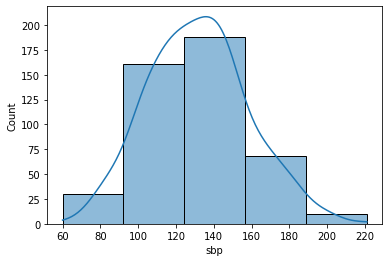

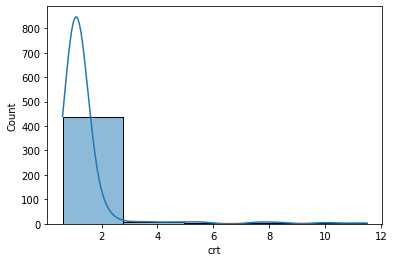

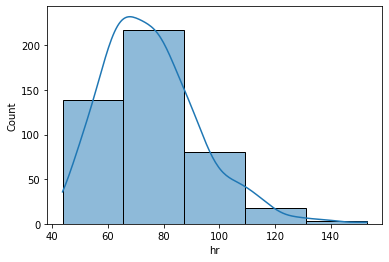

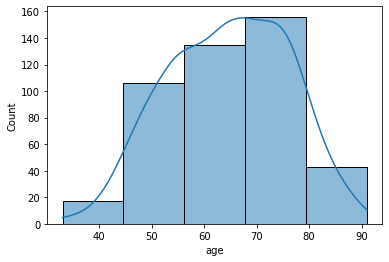

In [54]:
for col in ['sbp', 'crt', 'hr', 'age']:
    print(f'KS of {col}:', kstest(dataset[col], 'norm'))
    plt.figure()
    sns.histplot(
        dataset[col],
        bins=5,
        kde=True,
    )

Only 'sbp' follows a normal distribution, so we need to discretize the remaining variables (i.e 'crt', 'hr')

In [55]:
def discretize(dataset, col, nBins):
    '''
    Split continuous variables
    into bins
    '''
    bins = np.linspace(
        start=dataset[col].min(),
        stop=dataset[col].max(),
        num=nBins+1
    ).tolist()
    return pd.cut(x=dataset[col], bins=bins, labels=False, include_lowest=True)
    

In [56]:
def getProbs(dataset, colName, nBins):
    '''
    Returns conditional probabilities
    for each bin contained in
    a continuous variable
    '''
    bins = discretize(dataset, colName, nBins)
    print(bins)
    df = pd.concat([dataset['target'], bins], axis=1)
    probs = {str(bin): [] for _, bin in enumerate(np.unique(bins))}
    for name, g in df.groupby(['target', colName]):
        probs[str(name[1])].append(len(g))
    
    for k, v in probs.items():
        if len(v) == 1:
            v.append(0)
        t = v[0] / (v[0] + v[1])
        _t = v[1] / (v[0] + v[1])
        probs[k][0] = t
        probs[k][1] = _t
    
    return probs

In [57]:
crtBins = 3
hrBins = 5
ageBins = 4
dataset['crt_disc'] = discretize(dataset, 'crt', crtBins)
dataset['hr_disc'] = discretize(dataset, 'hr', hrBins)
dataset['age_disc'] = discretize(dataset, 'age', ageBins)

### 2. Processing the data

##### i. Continuous information

We wish to determine which posterior is greater, event or no event (in our case, target or ~target). <br />
For continuous data, we need to compute the mean and standard deviation of P(X|T) and P(X|~T), in which X corresponds to a given continuous variable and T is the target variable.

In [58]:
def getDistParams(dataset, cols):
    '''
    Computes distribution parameters
    for a set of 'cols'.
    Return a dict of lists, where
    list[0] is the mean, std of ~T
    list[1] is the mean, std of T.
    '''
    params = {col: [] for col in cols}
    for col in cols:
        _t = dataset[dataset['target'] == 0]
        t = dataset[dataset['target'] == 1]
        params[col].append((_t[col].mean(), _t[col].std()))
        params[col].append((t[col].mean(), t[col].std()))
    return params


Since we have discretized variables 'crt' and 'hr', the only truly continuous variable is 'sbp'. <br />
So we compute the distribution parameters for that variable and use them to know P('sbp'|T) and P('sbp'|~T).

In [59]:
sbpParams_T, sbpParamsT = getDistParams(dataset, ['sbp'])['sbp']

print(sbpParams_T, sbpParamsT)

(126.85971223021583, 25.750365654196678) (139.43016759776538, 26.39435983066514)


Given the distribution parameters, we can now compute the probability for any given value of 'sbp'

In [60]:
# P(sbpValue|T)
sbpProbsT = dataset.apply(
    lambda row: norm.pdf(row['sbp'], sbpParamsT[0], sbpParamsT[1]),
    axis=1
)
# P(sbpValue|~T)
sbpProbs_T = dataset.apply(
    lambda row: norm.pdf(row['sbp'], sbpParams_T[0], sbpParams_T[1]),
    axis=1
)

Then, we compute P(T|'sbp') and P(~T|'sbp'): <br />
P(T|'sbp') = P('sbp'|T) * P(T) <br />
P(~T|'sbp') = P('sbp'|~T) * P(~T) <br />

If: <br />
P(T|'sbp') > P(~T|'sbp') then T <br />
Else if: <br />
P(T|'sbp') < P(~T|'sbp') then ~T

In [61]:
# prob of T and prob of ~T
probT = len(dataset[dataset['target'] == 1]) / len(dataset)
prob_T = len(dataset[dataset['target'] == 0]) / len(dataset)

sbpProbsT *= probT
sbpProbs_T *= prob_T

In [62]:
dataset['cpred'] = np.where(sbpProbsT > sbpProbs_T, 1, 0)

##### ii. Discrete information

For discrete data, we need to compute: <br />
<ul>
    <li>P(T) - priori</li>
    <li>P(X|T) - likelihood</li>
    <li>P(X) - evidence</li>
</ul>
where X = {'gender', 'rf', 'st', 'kil', 'cg', 'crt',  'hr', 'age'}

In [63]:
def getLikelihood(dataset, row, cols):
    '''
    Computes likelihood for col in 'cols'.
    Outputs a dict of type
    {col: [P(colValues | target), P(colValues | ~target)]}
    '''
    pXT, pX_T = [], []
    t = dataset['target'] == 1
    _t = dataset['target'] == 0
    for col in cols:
        pXT.append(
            len(dataset[(t) & (dataset[col] == row[col])]) / len(t)
        )
        pX_T.append(
            len(dataset[(_t) & (dataset[col] == row[col])]) / len(_t)
        )
    return int(np.prod(pXT) * probT > np.prod(pX_T) * prob_T)

In [64]:
dataset['dpred'] = dataset.apply(
    lambda row: getLikelihood(
        dataset, row, 
        [
         'gender', 'rf', 'st',
         'kil', 'cg', 'crt_disc',
         'hr_disc', 'age_disc'
        ]
    ),
    axis=1
)

In [65]:
dataset['pred'] = (dataset['cpred'] < dataset['dpred']).astype(int)

### 3. Evaluation

In [66]:
def sens(tp, fn):
    return tp / (tp + fn)

def spec(fp, tn):
    return tn / (fp + tn)

def confMat(one, two):
    tn, fp, fn, tp = confusion_matrix(one, two).ravel()
    return tn, fp, fn, tp

In [67]:
tn, fp, fn, tp = confMat(
    dataset['cg'],
    dataset['pred']
)

print(
    f'''
    Confusion Matrix:
    [{tp}] [{fp}]
    [{fn}] [{tn}]
    Sensitivity : {round(sens(tp, fn), 4)}
    Specificity : {round(spec(fp, tn), 4)}
    F1 : {round(f1_score(dataset['cg'],dataset['pred']), 4)}
    '''
)


    Confusion Matrix:
    [68] [360]
    [1] [28]
    Sensitivity : 0.7083
    Specificity : 0.9972
    F1 : 0.8242
    
